In [2]:
require 'nn'
require 'nngraph'
require 'load_images'
require 'torch'
require 'optim'

nngraph.setDebug(true)
logger = optim.Logger('loss_log.txt')

images = load_images.load('datasets/Set14/image_SRF_4/', 'png', false)
inputChannels = 3

-- Convert greyscale images
for i = 1, #images do
        images[i] = images[i]:expand(inputChannels, images[i]:size(2), images[i]:size(3))
end

n = #images / 2

imagesLR = {}--images:select()
imagesHR = {}--images[2]

for i = 1, n do
	imagesLR[i] = images[2 * i]
	imagesHR[i] = images[2 * i - 1]
end


upscaleFactor = 4

net = nn.Sequential()
net:add(nn.SpatialConvolution(inputChannels, 8, 3, 3, 1, 1, 1, 1))
net:add(nn.ReLU())
net:add(nn.SpatialConvolution(8, 16, 3, 3, 1, 1, 1, 1))
net:add(nn.ReLU())
net:add(nn.SpatialConvolution(16, 32, 3, 3, 1, 1, 1, 1))
net:add(nn.ReLU())

net:add(nn.SpatialConvolution(32, inputChannels * upscaleFactor * upscaleFactor, 3, 3, 1, 1, 1, 1))
net:add(nn.PixelShuffle(upscaleFactor))

--graph.dot(net.fg, 'cnn1', 'cnn1')

criterion = nn.MSECriterion()

x, dl_dx = net:getParameters()

feval = function(x_new)
   
   if x ~= x_new then
      x:copy(x_new)
   end

   -- select a new training sample
   _nidx_ = (_nidx_ or 0) + 1
   if _nidx_ > #imagesHR then _nidx_ = 1 end

   --local sample = data[_nidx_]
   local target = imagesHR[_nidx_]      -- this funny looking syntax allows
   local inputs = imagesLR[_nidx_]    -- slicing of arrays.

   -- reset gradients (gradients are always accumulated, to accommodate 
   -- batch methods)
   dl_dx:zero()

   -- evaluate the loss function and its derivative wrt x, for that sample
   local loss_x = criterion:forward(net:forward(inputs), target)
   net:backward(inputs, criterion:backward(net.output, target))

   -- return loss(x) and dloss/dx
   return loss_x, dl_dx
end

sgd_params = {
   learningRate = 1e-3,
   learningRateDecay = 1e-4,
   weightDecay = 0,
   momentum = 0
}

for i = 1,5 do

   -- this variable is used to estimate the average loss
   current_loss = 0

   -- an epoch is a full loop over our training data
   for i = 1, #imagesHR do
      
      _,fs = optim.sgd(feval,x,sgd_params)


      current_loss = current_loss + fs[1]
   end

   -- report average error on epoch
   current_loss = current_loss / #imagesHR
   print('current loss = ' .. current_loss)
   
   logger:add{['training error'] = current_loss}
   logger:style{['training error'] = '-'}
   if i%200 == 0 then
   logger:plot()  
   end
end

current loss = 0.28761626608327	


current loss = 0.28717842057108	


current loss = 0.2867421262701	


current loss = 0.28630727033315	


current loss = 0.28587375832508	


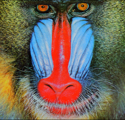

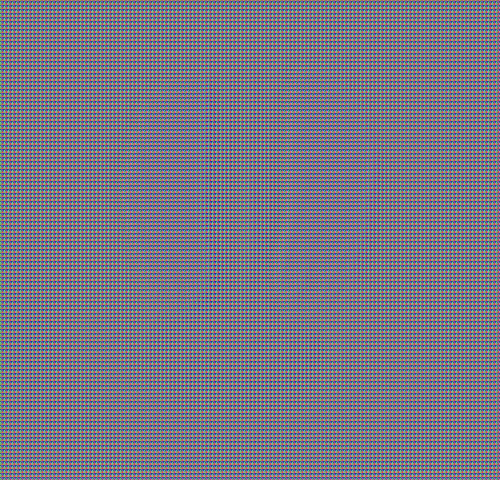

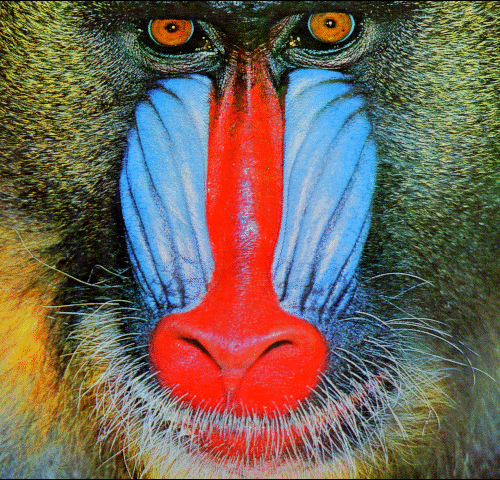

In [3]:
local origin = imagesLR[1]
local gt = imagesHR[1]
local test = net:forward(origin)

image.save("test.png", test)

itorch.image(origin)
itorch.image(test)
itorch.image(gt)